In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers

import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import os
import json

# from tqdm import tqdm

In [2]:
SEED_NUM = 17171771
tf.random.set_seed(SEED_NUM)

DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'
TRAIN_INPUT_DATA = 'train_input.npy'
TRAIN_LABEL_DATA = 'train_label.npy'
TEST_INPUT_DATA = 'test_input.npy'
TEST_LABEL_DATA = 'test_label.npy'
SAVE_FILE_NM = 'weights.h5'
DATA_CONFIGS = 'data_configs.json'

trainInputs = np.load(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'rb'))
trainInputs = pad_sequences(trainInputs, maxlen=trainInputs.shape[1])
trainLabel = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'rb'))
preproConfigs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

print(trainInputs)
# print(preproConfigs)

[[  403     7   237 ...  6678    28     1]
 [  364   209  1852 ...     1   133     1]
 [  979   862   870 ...     0     0     0]
 ...
 [ 2129  1755 17005 ...     0     0     0]
 [  281   247    77 ...   943   155    72]
 [   41     6   255 ...     0     0     0]]


In [3]:
modelName = 'rnn_classifier_kr'
BATCH_SIZE = 128
NUM_EPOCHS = 5
VALID_SPLIT = 0.1
MAX_LEN = trainInputs.shape[1]

kargs = {'model_name':modelName,
        'vocab_size':preproConfigs['vocab_size'],
         'embedding_dimension':100,
         'dropout_rate':0.2,
         'lstm_dimension':150,
         'dense_dimension':150,
         'output_dimension':1}

In [4]:
class RNNClassifier(tf.keras.Model):
    def __init__(self, **kargs):
        print('init keras rnn!!')
        super(RNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'],
                                         output_dim=kargs['embedding_dimension'])
        self.lstm_1_layer = tf.keras.layers.LSTM(kargs['lstm_dimension'],
                                                return_sequences=True)
        self.lstm_2_layer = tf.keras.layers.LSTM(kargs['lstm_dimension'])
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['dense_dimension'],
                               activation=tf.keras.activations.tanh)
        self.fc2 = layers.Dense(units=kargs['output_dimension'],
                               activation=tf.keras.activations.sigmoid)
        
    def call(self, x):
        print('call rnn!!')
        x = self.embedding(x)
        x = self.dropout(x)
        x = self.lstm_1_layer(x)
        x = self.lstm_2_layer(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
        

In [5]:
model = RNNClassifier(**kargs)
model.compile(optimizer = tf.keras.optimizers.Adam(1e-4),
             loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

init keras rnn!!


In [6]:
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=2)
checkpoint_path = DATA_OUT_PATH + modelName + '/' + SAVE_FILE_NM

cp_callback = ModelCheckpoint(checkpoint_path,monitor='val_accuracy', verbose=1, save_best_only=True,save_weights_only=True)
history = model.fit(trainInputs,trainLabel, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_split=VALID_SPLIT, callbacks=[earlystop_callback,cp_callback])


Epoch 1/5
call rnn!!
call rnn!!
182/182 [==============================] - 127s 678ms/step - loss: -1.4864 - accuracy: 0.9278 - val_loss: -2.5025 - val_accuracy: 0.9300

Epoch 00001: val_accuracy improved from -inf to 0.93003, saving model to ./data_out/rnn_classifier_kr/weights.h5
Epoch 2/5
182/182 [==============================] - 134s 739ms/step - loss: -2.8114 - accuracy: 0.9301 - val_loss: -2.9515 - val_accuracy: 0.9300

Epoch 00002: val_accuracy did not improve from 0.93003
Epoch 3/5
182/182 [==============================] - 116s 639ms/step - loss: -3.2358 - accuracy: 0.9301 - val_loss: -3.3261 - val_accuracy: 0.9300

Epoch 00003: val_accuracy did not improve from 0.93003


In [7]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

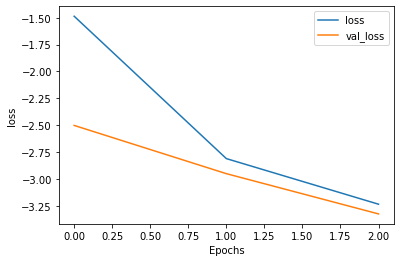

In [8]:
plot_graphs(history, 'loss')

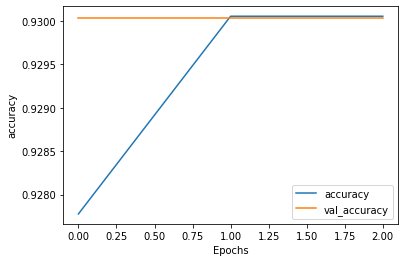

In [9]:
plot_graphs(history, 'accuracy')

In [10]:
testInput = np.load(open(DATA_IN_PATH + TEST_INPUT_DATA, 'rb'))
testInput = pad_sequences(testInput, maxlen=testInput.shape[1])
testLabelData = np.load(open(DATA_IN_PATH + TEST_LABEL_DATA, 'rb'))
print(type(model))
model.load_weights(os.path.join(DATA_OUT_PATH, modelName, SAVE_FILE_NM))
model.evaluate(testInput, testLabelData)

<class '__main__.RNNClassifier'>
347/347 [==============================] - 28s 81ms/step - loss: -2.5952 - accuracy: 0.9297


[-2.5951664447784424, 0.9297184944152832]

In [13]:
# prediction = model.predict(np.array([testInput[11]]))
prediction = model.predict(testInput)

print(prediction[0:80])



[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [11]:
builder = tf.saved_model.builder.SavedModelBuilder(DATA_OUT_PATH + 'rnn_build_model')
builder.add_meta_graph_and_variiables(sess, [tf.saved_model.tag_constants.SERVING], signature_def_map = {'predict_images':pre})

AttributeError: module 'tensorflow._api.v2.saved_model' has no attribute 'builder'